<a href="https://colab.research.google.com/github/kangel429/DeepLearning/blob/master/lesson5_sgd_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
from fastai.basics import *

## MNIST SGD

Get the 'pickled' MNIST dataset from http://deeplearning.net/data/mnist/mnist.pkl.gz. We're going to treat it as a standard flat dataset with fully connected layers, rather than using a CNN.

In [0]:
from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path = Config().data_path()/'mnist'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/root/.fastai/data/mnist')

In [0]:
path.ls()

[]

In [0]:
! cp /content/drive/'My Drive'/etc/mnist.pkl.gz  /root/.fastai/data/mnist


In [0]:
with gzip.open(path/'mnist.pkl.gz', 'rb') as f:       #압축을 풀지 않아도 바로 읽을 수 있게 한다 그 내용을 f에 집어넣음 .gzip으로 읽으면 파일 원본 내용 출력
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1') #f를 읽을 때 인코딩 latin-1 방식으로 읽음 그래서 그내용을 x_train, y_train), (x_valid, y_valid)집어넣음

(50000, 784)

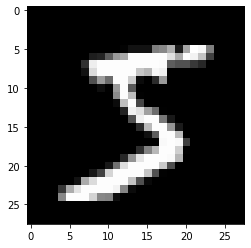

In [0]:
plt.imshow(x_train[0].reshape((28,28)), cmap="gray") #28사이즈의 이미지로 변환해서 그레이스케일로 보여줌
x_train.shape  #훈련 크기   28*28 = 784

In [0]:
x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))  # (x_train,y_train,x_valid,y_valid)을 tensor형태로 변환
n,c = x_train.shape       # n = 50000 c = 784
x_train.shape, y_train.min(), y_train.max()  # y_train 최소 최대

(torch.Size([50000, 784]), tensor(0), tensor(9))

In lesson2-sgd we did these things ourselves:

```python
x = torch.ones(n,2) 
def mse(y_hat, y): return ((y_hat-y)**2).mean()
y_hat = x@a
```

Now instead we'll use PyTorch's functions to do it for us, and also to handle mini-batches (which we didn't do last time, since our dataset was so small).

In [0]:
bs=64
train_ds = TensorDataset(x_train, y_train) #x_train, y_train 데이터를 묶어놓기 ---> 데이터가 늘어나거나 신경망 계층의 증가 또는 파라미터가 늘어나면서 전체 데이터를 메모리에서 처리하기가 어려워집니다. 이 문제를 해결하기 위하여
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs)  #data에 훈련, 검증 데이터를 집어넣기

In [0]:
x,y = next(iter(data.train_dl)) #next --> 하나씩 iter 매소드를 호출
x.shape,y.shape

(torch.Size([64, 784]), torch.Size([64]))

In [0]:
class Mnist_Logistic(nn.Module):        # MNIST 로지스틱 모델을 만들 선형 계층
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10, bias=True) 28*28 = 784, 0~9 숫자-->10

    def forward(self, xb): return self.lin(xb)

In [0]:
model = Mnist_Logistic().cuda()    # model = 선형 계층

In [0]:
model                   #model이 뭔지 알려줌

Mnist_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [0]:
model.lin             #Linear(in_features=784, out_features=10, bias=True)

Linear(in_features=784, out_features=10, bias=True)

In [0]:
model(x).shape        #torch.Size([64, 10])

torch.Size([64, 10])

In [0]:
[p.shape for p in model.parameters()]

[torch.Size([10, 784]), torch.Size([10])]

In [0]:
lr=2e-2               #lr 학습 속도

In [0]:
loss_func = nn.CrossEntropyLoss()  #다중분류를 위한 손실함수 

In [0]:
def update(x,y,lr):
    wd = 1e-5
    y_hat = model(x)       #y_hat = Mnist_Logistic.cuda()을 사용하여 예측된 값
    # weight decay
    w2 = 0.
    for p in model.parameters(): w2 += (p**2).sum()
    # add to regular loss
    loss = loss_func(y_hat, y) + w2*wd    #loss 구하는 
    loss.backward()         #역전파
    with torch.no_grad():     #기록을 추적하는 것(과 메모리를 사용하는 것)을 방지하기 위해
        for p in model.parameters():    
            p.sub_(lr * p.grad)
            p.grad.zero_()
    return loss.item()

In [0]:
losses = [update(x,y,lr) for x,y in data.train_dl]  #손실(loss; 출력이 정답으로부터 얼마나 떨어져있는지)을 계산합니다.

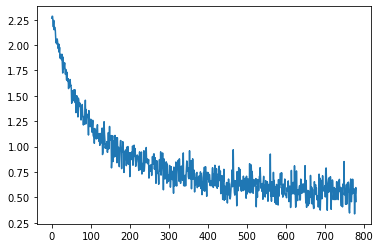

In [0]:
plt.plot(losses);         #손실 그래프 보여줌

In [0]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True)  #2개의 레이어로 구성된 모델 설계
        self.lin2 = nn.Linear(50, 10, bias=True)

    def forward(self, xb):
        x = self.lin1(xb)
        x = F.relu(x)     #첫번째 레이어 relu 활성함수 사용
        return self.lin2(x) # 두 번째 레이어 lin2

In [0]:
model = Mnist_NN().cuda()

In [0]:
losses = [update(x,y,lr) for x,y in data.train_dl]    #손실(loss; 출력이 정답으로부터 얼마나 떨어져있는지)을 계산합니다.

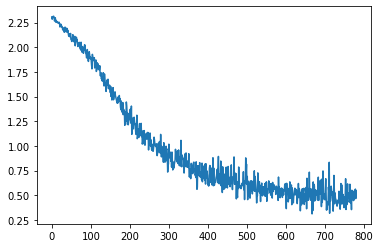

In [0]:
plt.plot(losses);

In [0]:
model = Mnist_NN().cuda()

In [0]:
def update(x,y,lr):
    opt = optim.Adam(model.parameters(), lr)    #Adam은 Momentum과 RMSprop를 합친 경사 하강법 
    y_hat = model(x)      #y_hat = Mnist_NN().cuda()을 사용하여 예측된 값
    loss = loss_func(y_hat, y)    #loss 구하는 함수  
    loss.backward()           #역전파
    opt.step()                  # Adam은을 사용하여 가중치를 갱신합니다.
    opt.zero_grad()           #  가중치 갱신 후에는 수동으로 변화도를 0으로 만듭니다.
    return loss.item()

In [0]:
losses = [update(x,y,1e-3) for x,y in data.train_dl] # 훈련시킴

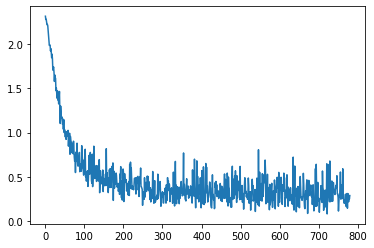

In [0]:
plt.plot(losses);         #훈련시킨 결과 -- 얼마나 los가 많은지

In [0]:
learn = Learner(data, Mnist_NN(), loss_func=loss_func, metrics=accuracy)  #Mnist_NN() 모델, 정확도 체크

In [0]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


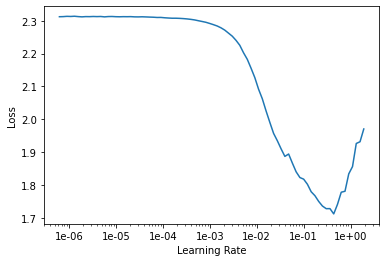

In [0]:
learn.lr_find()     #학습속도 찾아서
learn.recorder.plot() #그래프 그려줌

In [0]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.147761,0.127450,0.961500,00:03


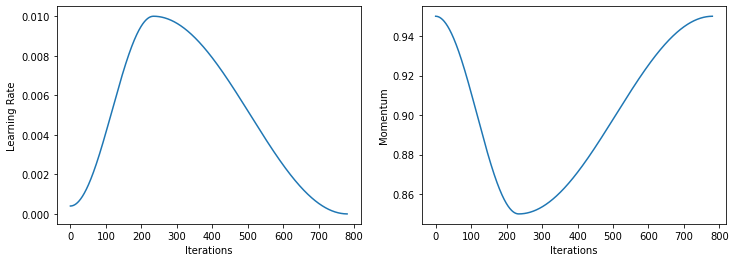

In [0]:
learn.recorder.plot_lr(show_moms=True)

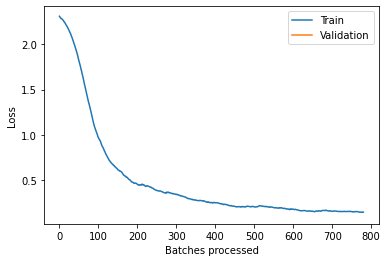

In [0]:
learn.recorder.plot_losses()

## fin